# Classification d'image vue de face de veaux avec Unet

## Import des dependances

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
import torch
import torch.nn as nn
import torchvision.models.segmentation as segmentation
from torchvision import models
from torchvision.transforms import v2
from torchvision.io import read_image
import numpy as np
import cv2
import os
import sys
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from tqdm import tqdm
import random
from PIL import Image as PilImage
from omnixai.data.image import Image
from omnixai.explainers.vision import LimeImage, VisionExplainer
from omnixai.preprocessing.image import Resize
from efficientnet_pytorch import EfficientNet
from torchsampler import ImbalancedDatasetSampler
from IPython.display import clear_output
import timm

# Local dep
project_dir = '/data/konrad/workspace'
sys.path.insert(0, project_dir)

from helpers.helpers import get_indices, load_face_data, load_local_model
from helpers.datasets import CalfCenterFaceDataset
from helpers.interp import GradCam, generate_cam, display_predicted_cam
from helpers.trainers import train_model, validate_model, plot_metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-08-28 15:26:52.103342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 15:26:52.116449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 15:26:52.119861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 15:26:52.131557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 15:26:53.025651: W tensorflow/compiler/tf2

## Classes et utilitaires

In [2]:
class Classifier(nn.Module):
    def __init__(self, num_classes, name, from_pretrained=True):
        super(Classifier, self).__init__()
        self.name = name
        
        # Load the EfficientNet backbone
        if from_pretrained:
            self.backbone = EfficientNet.from_pretrained('efficientnet-b3')  # You can choose other variants like 'efficientnet-b1', 'efficientnet-b2', etc.
        else:
            self.backbone = EfficientNet.from_name('efficientnet-b3')

        self.conv_head = self.backbone._conv_head  # 1280 is the number of output channels for EfficientNet-B0

       # Replace the original classifier head with a new one
        self.backbone._fc = nn.Linear(self.backbone._fc.in_features, num_classes)
        self.classifier_head = self.backbone._fc

    def forward(self, x):
        output = self.backbone(x)
        return output

## Entrainement du modele

### Dataset setup

In [3]:
# train_indices, test_indices, valid_indices = get_indices(len(df))
ROOT_DIR = "/data/konrad/workspace"
DATA_FILE = ROOT_DIR + "/csv_files/CompleteDatasetNormalFace/Face_annotations.csv"
IMAGE_DIR = ROOT_DIR + "/csv_files/CompleteDatasetNormalFace"
IMAGE_SIZE = 512

# dataset_type = "splt"
dataset_type = "loco"

# df, labels, label2id, id2label = load_face_data(DATA_FILE, IMAGE_DIR)
# root_dir = ROOT_DIR + f"/datasets/mixed_{frame}s_b{step}s"
# root_dir = f"/data/data_calves/konrad/mixed_{frame}s_b{step}s"

train_df = pd.read_csv(ROOT_DIR + f'/csv_files/mixed_10s_b0s_y7_1/{dataset_type}_train_image_extracted_metadata.csv', index_col=False)
valid_df = pd.read_csv(ROOT_DIR + f'/csv_files/mixed_10s_b0s_y7_1/{dataset_type}_test_image_extracted_metadata.csv', index_col=False)
test_df = pd.read_csv(ROOT_DIR + f'/csv_files/mixed_10s_b0s_y7_1/{dataset_type}_val_image_extracted_metadata.csv', index_col=False)

label_col = "bilabel"
# label_col = "label"
# train_df = train_df[~ (train_df[label_col] == "Diarrhé, Pneumonie")]
# valid_df = valid_df[~ (valid_df[label_col] == "Diarrhé, Pneumonie")]
# test_df = test_df[~ (test_df[label_col] == "Diarrhé, Pneumonie")]

labels = train_df[label_col].unique()
label2id = {l:i for i, l in enumerate(labels)}
id2label = {i:l for i, l in enumerate(labels)}

# num_labels = len(labels)
num_labels = 1
train_df['target'] = train_df.apply(lambda row: label2id[row[label_col]], axis=1)
test_df['target'] = test_df.apply(lambda row: label2id[row[label_col]], axis=1)
valid_df['target'] = valid_df.apply(lambda row: label2id[row[label_col]], axis=1)
test_df = test_df.sample(frac=.10).reset_index(drop=True)

train_transform = v2.Compose([
    v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = v2.Compose([
    v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CalfCenterFaceDataset(train_df, transform=train_transform)
test_dataset = CalfCenterFaceDataset(test_df, transform=test_transform)
valid_dataset = CalfCenterFaceDataset(valid_df, transform=test_transform)

# Data loaders
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_dataset))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size * 2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False)


### Entrainement et validation

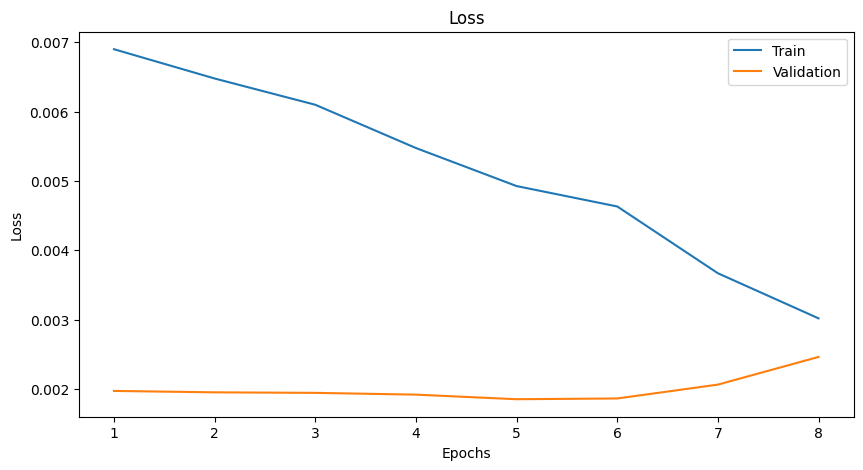

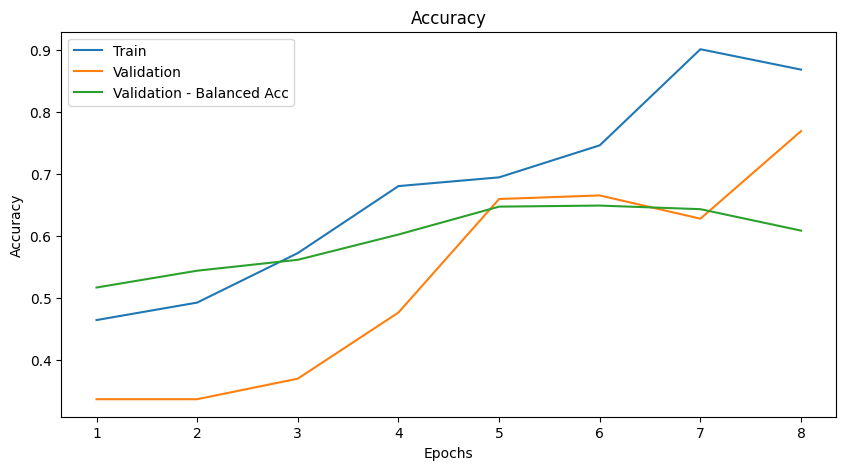

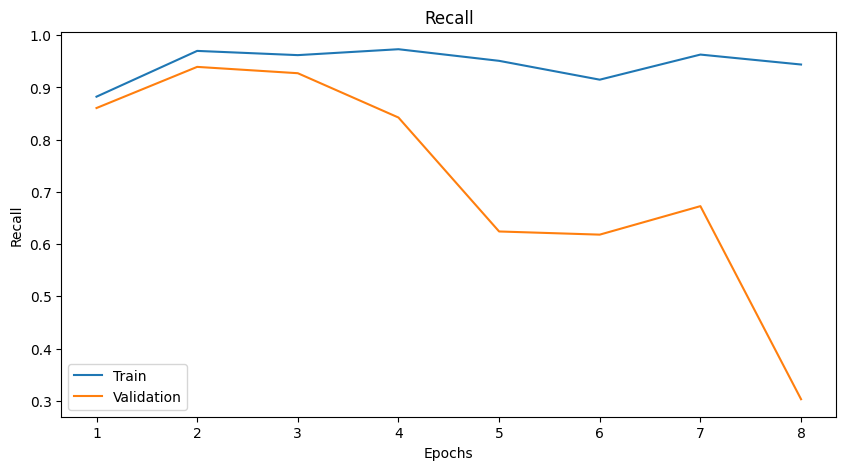

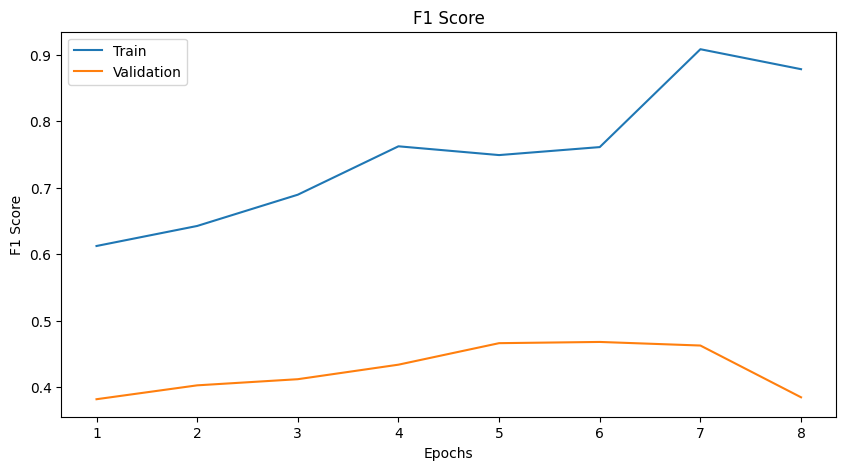

In [4]:
model_name = f"efficientnet_{dataset_type}_{label_col}_{batch_size}"
model = Classifier(num_classes=num_labels, name=model_name, from_pretrained=True)  # Adjust num_classes according to your dataset
model.to(device)

# Loss and optimizer
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

epochs = 15
patience = 3

if num_labels == 1:
    average = "binary"
else:
    average = "weighted"

output_dir = ROOT_DIR + "/training_log"
metrics_scores = train_model(model, labels, train_loader, test_loader, scheduler, patience, optimizer, output_dir, num_epochs = epochs, average=average)
clear_output()
plot_metrics(metrics_scores)

In [5]:
model.load_state_dict(torch.load(f'{output_dir}/models/best_{model.name}_model.pth'))
validate_model(model, valid_loader, labels, average=average)

Validating on 283 datas


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.56s/it]

Test Accuracy: 0.5371, Recall: 0.8624, F1 Score: 0.5893, Bal Acc Score: 0.5979


{'accuracy': 0.5371024734982333,
 'recall': 0.8623853211009175,
 'f1': 0.5893416927899687,
 'bal_acc': 0.597859327217125,
 'valid_loss': 0.004811542496706049}

## Interpretation with Lime

In [5]:
model_name = f"efficientnet_{dataset_type}_{label_col}_{batch_size}"
output_dir = ROOT_DIR + "/training_log"
model = Classifier(num_classes=num_labels, name=model_name, from_pretrained=False)  # Adjust num_classes according to your dataset
model.load_state_dict(torch.load(f'{output_dir}/models/best_{model.name}_model.pth'))
model = model.to(device)

In [ ]:
# Function to sample uniformly
def uniform_sample(df, sample_size, groupby_cols):
    # Calculate the number of rows to sample per group
    num_groups = df.groupby(groupby_cols).ngroups
    sample_per_group = max(sample_size // num_groups, 1)
    
    # Sample uniformly within each group
    sampled_df = df.groupby(groupby_cols, group_keys=False).apply(lambda x: x.sample(min(len(x), sample_per_group)))
    return sampled_df

# Specify the columns to group by and the sample size
groupby_cols = ['calf', 'bilabel']
sample_size = 1
# Get the uniformly sampled dataframe
sampled = uniform_sample(valid_df, sample_size, groupby_cols)
sampled = sampled.sample(frac=1).reset_index(drop=True)
sampled.shape
batch_size = 12
if num_labels == 1:
    average = "binary"
else:
    average = "weighted"
final_valid_dataset = CalfCenterFaceDataset(sampled, transform=test_transform)
valid_loader = DataLoader(final_valid_dataset, batch_size=batch_size * 2, shuffle=False)
validate_model(model, valid_loader, labels, average=average, plot_confusion = True)